# Gaussian process regression

Comparison to baselines

### Table of contents

1. [**Data**](#data)
3. [**SNN**](#snn)
4. [**RNN**](#rnn)

This notebook contains code demonstrating how to do regression.
- Linear regression
- Fitting a spike train with a renewal process GP
- Computing the renewal process likelihood landscape
- Performing GPLVM on a biological data for dimensionality reduction

### Gaussian place field

In [2]:
# Synthetic grid of place cells
sample_bin, track_samples, x_t, y_t, s_t, hd_t, theta_t, dir_t, \
            syn_t_spike, spike_samples, units, \
            left_x, right_x, bottom_y, top_y = pickle.load(open('./data/grid_IPP.p', 'rb'))

arena_width = right_x - left_x
arena_height = top_y - bottom_y

neurons = np.arange(units)
use_samples = 1000000
used_t_spike = [syn_t_spike[n][syn_t_spike[n] < use_samples] for n in neurons]
units_used = len(neurons)
unit_used = np.arange(units_used)
show_neurons = [0, 1, 2, 3, 4]
behav_data = (x_t, y_t)

bin_size = 500
tbin, resamples, rc_t, (rx_t, ry_t) = utils.neural.BinTrain(bin_size, sample_bin, used_t_spike, 
                                                            use_samples, behav_data, average_behav=False)

In [3]:
np.savez_compressed('CA1_synthetic', spktrain=rc_t, x_t=rx_t, y_t=ry_t)

### $R^2$-GPLVM

In [3]:
# base GP
base_d = 1
units_ = 2

num_induc = 64
inducing_points = np.array([np.linspace(0, resamples*tbin, num_induc)]).T[None, ...].repeat(units_, axis=0)

l = 1.0*np.ones(units_)
v = np.ones(units_)
kernels_tuples = [('OU', 'euclid', np.array([l]))]
gp_base = mdl.nonparametrics.Gaussian_process(
    base_d, units_, kernels_tuples, # mean fixed to zero by default
    inducing_points=inducing_points, inv_link='identity', whiten=True, jitter=1e-5
)



gp_base_input = mdl.inference.input_group(base_d, [(None, None, None, base_d)])

times_input = np.arange(resamples)*tbin
gp_base_input.set_XZ([times_input], resamples, batch_size=2000)

In [4]:
num_induc = 16
inducing_points = np.array([np.linspace(-1., 1, num_induc), \
                            np.random.randn(num_induc)]).T[None, ...].repeat(units_used, axis=0)
d = inducing_points.shape[-1]

VI_tuples = [('mapping', 'Normal', 'euclid', d)]

inputs = mdl.inference.input_group(d, VI_tuples)
ini_X = [
    [(gp_base_input, gp_base,), (np.random.randn(resamples, 2)*0.1, np.ones((resamples, 2))*0.01)]
]
inputs.set_XZ(ini_X, resamples, batch_size=2000)


# GPLVM or Deep GP
units_ = units_used#1
l = .5*np.ones(units_)
v = np.ones(units_)
kernels_tuples = [('variance', v), ('SE', 'euclid', np.array([l, l]))]



gp_lvm = mdl.nonparametrics.Gaussian_process(
    d, units_used, kernels_tuples, mean=np.zeros(units_used), learn_mean=True, 
    inducing_points=inducing_points, whiten=True, jitter=1e-5
)


likelihood = mdl.likelihoods.Poisson(tbin, units_used, 'exp')
likelihood.set_Y(rc_t, batch_size=2000)

# NLL model
glm = mdl.inference.VI_optimized(inputs, gp_lvm, likelihood)
glm.to(dev)

VI_optimized(
  (inputs): input_group(
    (p_inputs_0): input_group()
    (p_mapping_0): Gaussian_process(
      (kernel): Exponential()
    )
  )
  (mapping): Gaussian_process(
    (kernel): Product(
      (kern0): Constant()
      (kern1): RBF()
    )
  )
  (likelihood): Poisson()
)

In [5]:
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 50, sch)
opt_lr_dict = {'default': 1e-2,
               'inputs.lv_std_0': 1e-3}#, 'rate_model.0.lv_std_1': 1e-3}
glm.set_optimizers(opt_tuple, opt_lr_dict)

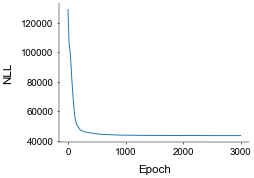

In [8]:
# fitting
annealing = lambda x: 1.0#min(1.0, 0.005*x)
losses = glm.fit(3000, loss_margin=1e2, margin_epochs=100, kl_anneal_func=annealing, 
                 cov_samples=16, ll_samples=50, ll_mode='GH')

plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.show()

In [24]:
del glm
del gp_lvm
del likelihood
del gp_base_1
del gp_base_2
torch.cuda.empty_cache()

NameError: name 'glm' is not defined

In [51]:
print(glm.rate_model[0].p_0.kernel.kern0.variance)
print(glm.rate_model[0].p_0.kernel.kern1.lengthscale)

tensor([[[[1.]]]], device='cuda:0', grad_fn=<ExpBackward>)
tensor([[[[11.7004]]]], device='cuda:0', grad_fn=<ExpBackward>)


27549.04887005676
15123.524000091631
15041.686962485448
27374.826455378803


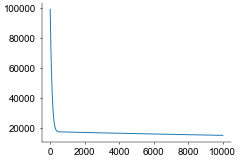

In [12]:
X_loc, X_std = glm.inputs.eval_XZ()
Xsig = X_loc[0].T
Xstd = X_std[0].T

rcov = np.concatenate((rx_t[None], ry_t[None]), axis=0)
scales_arr = [torch.tensor([rx_t.std()*2, ry_t.std()*2], device=dev), 
              torch.tensor([-rx_t.std()*2, ry_t.std()*2], device=dev), 
              torch.tensor([rx_t.std()*2, -ry_t.std()*2], device=dev), 
              torch.tensor([-rx_t.std()*2, -ry_t.std()*2], device=dev)]# take into account reflections

W_, bias_, scale_, losses_ = utils.latent.align_affine_2D(Xsig, rcov, scales_arr, dev=dev, iters=10000, lr=5*1e-3)
plt.plot(losses_[:])
plt.show()

aligned_loc = scale_[:, None]*(W_ @ Xsig + bias_[:, None])
aligned_std = np.sqrt(scale_[:, None]**2 *((W_**2).T @ Xstd**2))

In [13]:
covariates = np.arange(resamples)*tbin
#mean = gp_base_2.eval_rate(covariates[None, :], [0], n_samp=10000)[0]
lat_mean, lat_var = gp_base.compute_F(torch.tensor(covariates[None, :, None]).float().to(dev))
#lat_mean2, lat_var2 = gp_base_2(torch.tensor(covariates[None, :, None]).float().to(dev))

lat_mean = lat_mean.data.cpu().numpy()[0]
lat_dvar = lat_var.data.cpu().numpy()[0]

post_mean = scale_[:, None]*(W_ @ lat_mean + bias_[:, None])
post_std = np.sqrt(scale_[:, None]**2 *((W_**2).T @ lat_dvar))

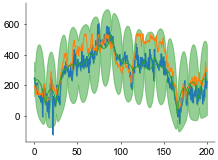

In [14]:
TT = 500

ax = plt.gca()
tx = np.arange(TT)*tbin

line, = ax.plot(tx, aligned_loc[0][:TT])
ax.fill_between(
    tx, aligned_loc[0][:TT]-aligned_std[0][:TT],
    aligned_loc[0][:TT]+aligned_std[0][:TT], color=line.get_color(), alpha=0.5
)

ax.plot(tx, rx_t[:TT])

line, = ax.plot(tx, post_mean[0][:TT])
ax.fill_between(
    tx, post_mean[0][:TT]-post_std[0][:TT],
    post_mean[0][:TT]+post_std[0][:TT], color=line.get_color(), alpha=0.5
)

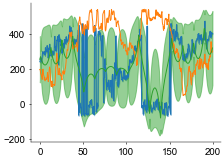

In [15]:
TT = 500

ax = plt.gca()
tx = np.arange(TT)*tbin

line, = ax.plot(tx, aligned_loc[1][:TT])
ax.fill_between(
    tx, aligned_loc[1][:TT]-aligned_std[1][:TT],
    aligned_loc[1][:TT]+aligned_std[1][:TT], color=line.get_color(), alpha=0.5
)

ax.plot(tx, rx_t[:TT])

line, = ax.plot(tx, post_mean[1][:TT])
ax.fill_between(
    tx, post_mean[1][:TT]-post_std[1][:TT],
    post_mean[1][:TT]+post_std[1][:TT], color=line.get_color(), alpha=0.5
)

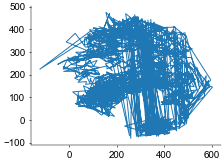

In [16]:
plt.plot(aligned_loc[0], aligned_loc[1])

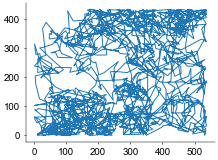

In [17]:
plt.plot(rx_t, ry_t)

In [20]:
grid_size = (50, 40)
grid_shape = [[left_x, right_x], [bottom_y, top_y]]

show_neurons = np.arange(units_used)

def func(pos):
    prevshape = pos.shape[1:]
    x = pos[0].flatten()
    y = pos[1].flatten()
    covariates = np.array([x, y])
    covariates = np.linalg.inv(W_) @ (covariates/scale_[:, None] - bias_[:, None])
    return gp_lvm.eval_rate(covariates, show_neurons).reshape(units_used, *prevshape)

_, field_fit = utils.plot.compute_mesh(grid_size, grid_shape, func)

In [45]:
# True tuning, grid of place fields
N_x = 5
N_y = 5
x_ = np.repeat(np.linspace(left_x, right_x, N_x+2)[1:-1], (N_x))
y_ = np.tile(np.linspace(bottom_y, top_y, N_y+2)[1:-1], (N_y))
imu = np.array([x_, y_]).T
neurons = imu.shape[0]
iprec = np.tile(np.array([0.0002, 0.0002, 0.0])[None, :], (neurons, 1))
irate_0 = np.tile(np.array([20.0]), (neurons)) # Hz
it_p = []
tt = np.linspace(0, 2*np.pi, neurons+1)
for n in range(neurons):
    it_p.append(np.array([0.6, tt[n]]))
it_p = np.array(it_p) # beta, phi_0 for theta modulation

glm_rate = rate_models.PTP_GLM(neurons, 'exp', decoding=True)
w = rate_models.gaussian_to_w(imu, iprec, irate_0, it_p)
glm_rate.set_params(sample_bin, w)

grid_size = [50, 40]
grid_shape = [[left_x, right_x], [bottom_y, top_y]]
neurons = N_x*N_y

def func(pos):
    prevshape = pos.shape[1:]
    x = pos[0].flatten()
    y = pos[1].flatten()
    theta = np.zeros_like(x)
    covariates = [x, y, theta]
    return glm_rate.eval_rate(covariates, np.arange(neurons)).reshape(neurons, *prevshape)

_, field_true = tools.compute_mesh(grid_size, grid_shape, func)

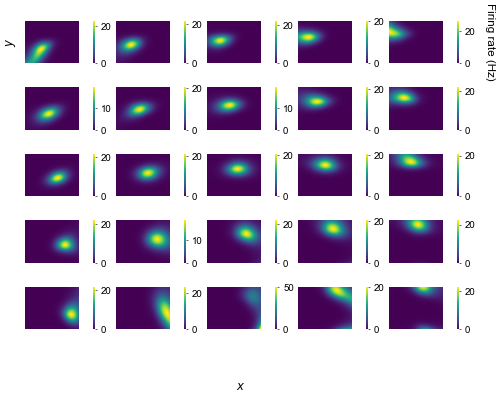

In [25]:
# show fits
grid_size = (50, 40)
grid_shape = [[left_x, right_x], [bottom_y, top_y]]

show_neurons = np.arange(25)

fig = plt.figure(figsize=(8, 6))
nrows = 5
ncols = 5
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

for m, neuron in enumerate(show_neurons):
    
    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = np.array([x, y])
        covariates = np.linalg.inv(W_) @ (covariates/scale_[:, None] - bias_[:, None])
        return gp_lvm.eval_rate(covariates, [neuron])[0].reshape(*prevshape)

    if neuron == 4:
        #cbar = True
        ticktitle='Firing rate (Hz)'
    else:
        #cbar = False
        ticktitle=''
        
    _, field = utils.plot.compute_mesh(grid_size, grid_shape, func)
    #grid_shape = [[-2., 2.], [-2., 2.]]
    im = utils.plot.visualize_field((fig, axes[m]), field, grid_shape, ticktitle=ticktitle)
    if m == 0:
        ylabel=r'$y$'
    else:
        ylabel=None
    utils.plot.decorate_ax(axes[m], ylabel=ylabel, spines=[False, False, False, False])
    #xlim=[left_x, right_x], ylim=[bottom_y, top_y],

fig.text(0.51, 0.0, r'$x$', ha='center', va='center', fontsize=12)

fig.subplots_adjust(hspace=0.3, wspace=0.3)


plt.show()

In [36]:
data_run = (aligned_loc, aligned_std, post_mean, post_std, # latent space
            rx_t, ry_t, tbin, # true latents
            field_true, field_fit) # tuning curves

In [25]:
# save model
model_name = "GPLVM_R2_1"
torch.save({'glm': glm.state_dict()}, './checkpoint/' + model_name)

In [37]:
pickle.dump(data_run, open('./checkpoint/GPLVM_R2_1_data.p', 'wb'))
#np.savez_compressed('./checkpoint/GPLVM_R2_1_data', rc_t=rc_t, rx_t=rx_t, ry_t=ry_t)